## Baby Yoda - Sith or Jedi?



In this jam project, I posed this pressing question, targeting the most recent Star Wars TV show and the cute internet meme it has brought to life. I aimed to answer this question by extracting various features characteristics to both Jedi and Sith masters across the Star Wars universe and building a simple ML model to see which features split these two fractions the best.

To be a bit more specific: being a sith or a Jedi is treated as a binary flag here, while the features I used were derived from the bio, the textual description, and the co-mention network of the sith and Jedi masters on the online platform called Wookiepedia.

Disclaimer: This project is not an official scientific research of any sort but an illustration of how different tools and methods of data science can be used to answer even seemingly wtf questions and to have some geek fun.

The notebook is organized as follows:

1-2. Downloading the sith and Jedi listings and the masters' profiles
3. Extracting textual and biographical features about the individuals
4. Quickly exploring and imputing these features
5. Building the co-occurrence network and computing network properties as individual features
6. Doing the prediction with the beloved XGHBoost

+1. Some extra viz, mostly lightsaber bar charts

In [60]:
# import bs4
import re
import os
import scipy
from urllib.request import urlopen
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import re
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
from spacy_readability import Readability
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier as XGB
import warnings
from random import randint, uniform
import matplotlib.pyplot as plt
import math
warnings.filterwarnings("ignore")
plt.style.use('seaborn-dark-palette')



analyzer = SentimentIntensityAnalyzer()
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe(Readability())

def format_axis(ax, xlabel, ylabel):   
    for pos in ['right', 'top', 'left']:
        ax.spines[pos].set_edgecolor('white')    
    ax.tick_params(axis='x', length=6, width=2, colors='black')
    ax.tick_params(axis='y', length=6, width=2, colors='black')
    ax.set_xlabel(xlabel, fontsize = 14)
    ax.set_ylabel(xlabel, fontsize = 14)
    
    
def axis_format_b(ax):
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_edgecolor('k')
        ax.spines[pos].set_linewidth(0)  

    ax.spines['left'].set_edgecolor('lightgrey')  
    ax.spines['left'].set_linewidth(3)  
    ax.spines['bottom'].set_edgecolor('lightgrey')  
    ax.spines['bottom'].set_linewidth(3)  
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')    

### 1. get the list of sith and jedi masters

The primary data source of this project was Wookipedia, available at https://starwars.fandom.com which contains full bios of the majority of the Sith and Jedi masters in various depths. These bio sites contain i) textual descriptions of the individuals, such as their history and adventures, ii) references to other characters of the franchise, iii) and usually basic biographic information, such as gender as well.

In [8]:
# first, let's get the listings of the Sith and Jedi masters

def get_ids(url, order):
    
    with urlopen(url) as site:
        html = site.read()
        soup = bs4.BeautifulSoup(html,"lxml")
        bios = soup.find_all('a', {'class' : 'category-page__member-link'})
        df   = pd.DataFrame([(p.text, url0 + str(p).split('href="')[1].split('"')[0]) for p in bios], columns = ['name', 'url'])
        df.index = df.name
        df[['url']].to_csv(order + '_name_urls.csv')
        print('Number of individuals listed as ', order, 'masters', len(df))

url0      = 'https://starwars.fandom.com/'
url_siths = 'https://starwars.fandom.com/wiki/Category:Sith_Masters'
url_jedi  = 'https://starwars.fandom.com/wiki/Category:Jedi_Masters_of_the_Jedi_Order'

get_ids(url_jedi,  'jedi')
get_ids(url_siths, 'sith')

### 2. crawl the profiles of the sith and jedi masters

By simple web crawling, I slowly, respecting the guidelines of the host server, downloaded the html for each master.

Note: some additional manual check was needed as for instance there were some 'Unidentified...' individuals included in the listings.

In [10]:
# After getting the master-name listings, let's crawl their profiles one by one

def crawl_profiles(df, order):
    
    folderout = 'html_' + order
    if not os.path.exists(folderout):
        os.makedirs(folderout)

    print(len(set(df.url)))   
    for name, url in dict(df)['url'].items():
        if not os.path.exists(folderout + '/' + name + '.html') and '/' not in name:
            print(name, url)
            with urlopen(url) as site:
                fout = open(folderout + '/' + name + '.html', 'w')
                fout.write(str(site.read()))
                fout.close()
            
    print(order, ' order crawled profiles: ', len(os.listdir(folderout)))
        

df_j = pd.read_csv('jedi_name_urls.csv', index_col = 0)  
df_s = pd.read_csv('sith_name_urls.csv', index_col = 0)  


# adding baby yoda as a jedi for now
df_by = pd.DataFrame([{'name' : 'The Child' , 'url' : 'https://starwars.fandom.com/wiki/The_Child'}])
df_by = df_by.set_index('name')
df_j  = df_j.append(df_by)

# https://starwars.fandom.com//wiki/Anakin_Skywalker    
crawl_profiles(df_s, 'sith')   
crawl_profiles(df_j, 'jedi')   

### 3. Parse the masters' profiles

Once the data was collected its time to start building the individual's profile. As the example of Obi-Wan Kenobi shows, the info table contains various sorts of information. Unfortunately, for less popular fellows, these tables are rather spars which I resolved by random imputation (inserting random values to the missing places according to these values' original distribution on the data). This resulted in the bio-type of features.

In addition, I run some text processing algos as well to extract basic features about the individual profile descriptions. These are the length of the text (number of sentences), the complexity and the readability of the text, and their sentiment scores (pos/neg/neutral).

To connect, these two types of features in the JediSithPorfiles.csv table are referred to as:

- 'Bio_NumSent' 
- 'Bio_Readability' 
- 'Bio_Sent_pos'
- 'Bio_Sent_neu'
- 'Bio_Sent_neg' 
- 'Bio_Sent_comp' 
- 'Order' 
- 'Gender'
- 'Species' 
- 'Hair color' 
- 'Eye color' 
- 'Skin color' 
- 'Height' 
- 'Born'

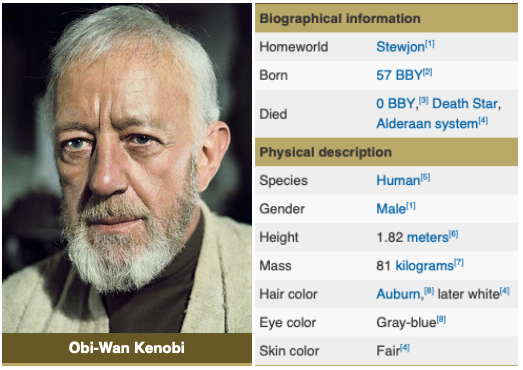

In [11]:
# reading the saved datasets, still split according to their orders
df_j = pd.read_csv('jedi_name_urls.csv', index_col = 0)  
df_s = pd.read_csv('sith_name_urls.csv', index_col = 0)

# adding baby yoda as a jedi for now
df_by = pd.DataFrame([{'name' : 'The Child' , 'url' : 'https://starwars.fandom.com/wiki/The_Child'}])
df_by = df_by.set_index('name')
df_j  = df_j.append(df_by)

df_all = df_j.append(df_s)

In [35]:
# let's parse all the htmls and seek for the various features in them
colors   = ['green', 'blue', 'yellow', 'orange', 'purple']
all_data = []

for order in ['jedi', 'sith']:

    folderout = 'html_' + order
    files     = [a for a in os.listdir(folderout) if '.DS' not in a]

    for fn in files:
        with open(folderout + '/' + fn) as myfile:

            # parsing the html
            html   = myfile.read()
            soup   = bs4.BeautifulSoup(html,"lxml")
            bios   = soup.findAll('div', {'class' : "pi-item pi-data pi-item-spacing pi-border-color"})
            data   = {}
            lsaber = np.nan
            text   = ' '.join([p.text.replace('\\n', '').replace('\\', '')  for p in soup.find_all('p')])
            sent   = sent_tokenize(text)

            # extracting the possible color of the lightsaber
            for s in sent:
                if 'lightsaber' in s:
                    words = word_tokenize(s.lower().replace('-', ' '))
                    for c in colors:
                        for w in words:
                            if  c  in w and 'print' not in c:
                                lsaber = w.replace('\\n', ' ').replace('\\t ', ' ').strip().rstrip()
                                break

            # extracting bio features
            for (html_tag, category) in [('data-source="birth',   'Born'), 
                                         ('title="Sexes',         'Gender'),
                                         ('data-source="species', 'Species'),
                                         ('data-source="hair',    'Hair color'),
                                         ('data-source="eyes',    'Eye color') ,
                                         ('data-source="skin',    'Skin color'),
                                         ('data-source="height', 'Height')]:

                for s in bios:
                    if html_tag in str(s):
                         data[category] = s.text.strip().replace(category, '').replace('\\n', '').split('[')[0].replace('\\t', '')

            # getting textual features
            doc = nlp(text)
            vs  = analyzer.polarity_scores(text)

            data['Bio_NumSent']     = len(sent_tokenize(soup.text))
            data['Bio_Readability'] = doc._.automated_readability_index
            data['Bio_Sent_pos']    = doc._.automated_readability_index

            data['Bio_Sent_pos']    = vs['pos']
            data['Bio_Sent_neu']    = vs['neu']
            data['Bio_Sent_neg']    = vs['neg']
            data['Bio_Sent_comp']   = vs['compound']

            data['Name']  = fn.split('.')[0].replace('_', ' ').replace('%27', '\' ')
            data['Order'] = order
            if order == 'sith':
                data['Lightsaber'] = 'red'
            else:
                data['Lightsaber'] = lsaber

            all_data.append(data)

            
            
df = pd.DataFrame(all_data)
print(len(df))
df.index = df.Name
df = df.drop(columns = ['Name'])
df = df.merge(df_all, right_index = True, left_index = True)
df.to_csv('JediSithPorfiles.csv', sep = '\t') 
df

225


,Bio_NumSent,Bio_Readability,Bio_Sent_pos,Bio_Sent_neu,Bio_Sent_neg,Bio_Sent_comp,Order,Lightsaber,Gender,Species,Hair color,Eye color,Skin color,Height,Born,url
Meloria's Jedi Master,18,7.195312,0.000,1.000,0.000,0.0000,jedi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://starwars.fandom.com//wiki/Meloria%27s_...
Cin Drallig,57,11.459131,0.033,0.844,0.123,-0.9976,jedi,green,Male,Human,Dark blond,Blue,Light,1.74 meters,NaN,https://starwars.fandom.com//wiki/Cin_Drallig
K'ungfu,26,11.757887,0.132,0.808,0.060,0.9226,jedi,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,https://starwars.fandom.com//wiki/K%27ungfu
Rana Kant,18,6.817319,0.000,1.000,0.000,0.0000,jedi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://starwars.fandom.com//wiki/Rana_Kant
Jai Maruk,23,11.246762,0.037,0.862,0.101,-0.9610,jedi,blue,Male,Human,NaN,NaN,NaN,NaN,NaN,https://starwars.fandom.com//wiki/Jai_Maruk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Anakin Skywalker,3091,12.974591,0.080,0.782,0.138,-1.0000,sith,red,Male,Human,Blond,"Blue,","Fair,","1.88 meters,",41 BBY,https://starwars.fandom.com//wiki/Anakin_Skywa...
Jorak Uln,110,10.528205,0.051,0.836,0.114,-0.9984,sith,red,Male,Human,Gray,White,Pale,NaN,NaN,https://starwars.fandom.com//wiki/Jorak_Uln
Darth Guile,24,10.663835,0.031,0.921,0.049,-0.5423,sith,red,Male,NaN,NaN,NaN,NaN,NaN,NaN,https://starwars.fandom.com//wiki/Darth_Guile
Githany,130,11.542990,0.097,0.772,0.132,-0.9985,sith,red,Female,Human,Black,Green,Light Brown,NaN,NaN,https://starwars.fandom.com//wiki/Githany


### 4. Explore, impute and preproc the bio features

#### 4.1 Describe features

In [12]:
df = pd.read_csv('JediSithPorfiles.csv', sep = '\t', index_col = 0)  

# some ugly cleaning steps
df['Gender']     = [g.split(' (')[0] if type(g) is str else g for g in list(df.Gender)]
df['Lightsaber'] = ['green' if '\\t' in str(g) else g for g in list(df.Lightsaber)]

Counter(df['Lightsaber'])

Counter({nan: 85,
         'green': 17,
         'blue': 18,
         'purple': 1,
         'yellow': 4,
         'red': 97})

In [13]:
print('Most common values:')
for key in df.drop(columns = ['url']).keys(): 
    print(key, '\t\t',  Counter(df[key].dropna()).most_common(3))

Most common values:
Bio_NumSent 		 [(23, 11), (21, 10), (20, 10)]
Bio_Readability 		 [(10.69636904761905, 3), (7.1953125, 1), (11.4591309071157, 1)]
Bio_Sent_pos 		 [(0.0, 32), (0.069, 8), (0.068, 6)]
Bio_Sent_neu 		 [(1.0, 10), (0.8079999999999999, 4), (0.9540000000000001, 4)]
Bio_Sent_neg 		 [(0.0, 19), (0.10099999999999999, 5), (0.13, 5)]
Bio_Sent_comp 		 [(-1.0, 19), (0.0, 11), (-0.9999, 10)]
Order 		 [('jedi', 125), ('sith', 97)]
Lightsaber 		 [('red', 97), ('blue', 18), ('green', 17)]
Gender 		 [('Male', 137), ('Female', 46)]
Species 		 [('Human', 66), ('Sith', 8), ("Twi\\'lek", 7)]
Hair color 		 [('Black', 19), ('White', 13), ('Brown', 10)]
Eye color 		 [('Yellow', 19), ('Blue', 18), ('Brown', 14)]
Skin color 		 [('Light', 18), ('Fair', 12), ('Green', 8)]
Height 		 [('1.88 meters', 3), ('1.96 meters', 2), ('1.93 meters', 2)]
Born 		 [('102 BBY,', 2), ('41 BBY (Approximate date)', 1), ('509 BBY', 1)]


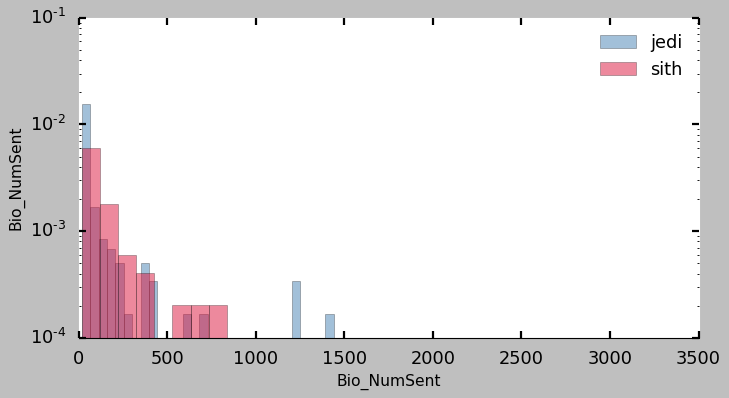

In [61]:
### compare the bio lengths
f, ax = plt.subplots(1,1,figsize = (10,5))

ax.hist(df[df.Order=='jedi'].Bio_NumSent, bins = 30, density = True, label = 'jedi', color = 'steelblue', alpha = 0.5)
ax.hist(df[df.Order=='sith'].Bio_NumSent, bins = 30, density = True, label = 'sith', color = 'crimson',   alpha = 0.5)

format_axis(ax, 'Bio_NumSent', 'Fraction of individuals')
ax.legend(loc = 'best', frameon = False)
ax.set_yscale('log')

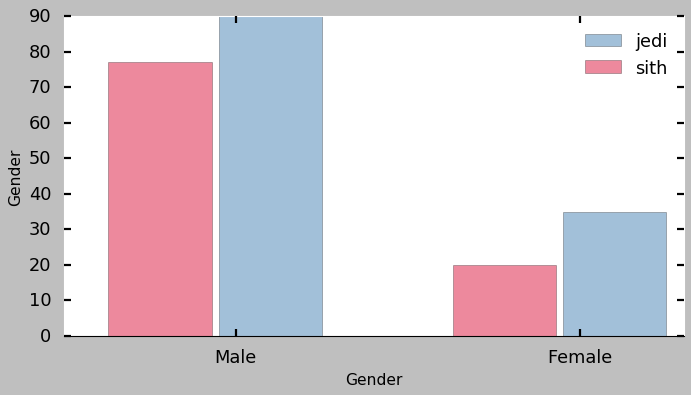

In [62]:
# apparently, jedi are doing slightly better, still pretty bad in gender-balance

def compare_gender(df, feat):
    
    x_j, y_j = zip(*[(a, b) for a, b in Counter(list(df[df.Order=='jedi'][feat].dropna())).most_common(10000)])
    y_s      = {a : b for a, b in Counter(list(df[df.Order=='sith'][feat].dropna())).most_common(10000)}

    f, ax = plt.subplots(1,1,figsize = (10,5))
    ax.bar([a + 0.6 for a in range(len(y_j))], y_j,    label = 'jedi', color = 'steelblue', width = 0.3,  alpha = 0.5, edgecolor = 'k')
    ax.bar([a + 0.28 for a in range(len(y_j))],  [y_s[xj] for xj in x_j], label = 'sith', color = 'crimson',   width = 0.3,  alpha = 0.5, edgecolor = 'k')

    ax.set_xticks([a + 0.5 for a in range(len(y_j))])
    ax.set_xticklabels(x_j, ha = 'center')

    format_axis(ax, 'Gender', 'Number of individuals')
    ax.legend(loc = 'best', frameon = False)

  
# compare genders
compare_gender(df, 'Gender')


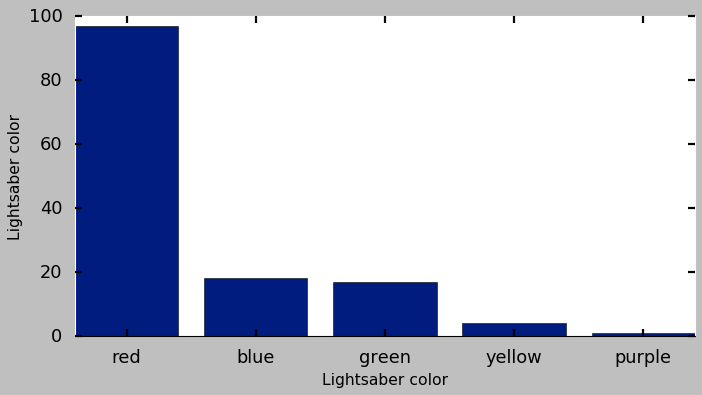

In [63]:
# the frequency distribution of the different lightsaber colors
x, y = zip(*[(a, b) for a, b in Counter(list(df.Lightsaber.dropna())).most_common(10000)])

f, ax = plt.subplots(1,1,figsize = (10,5))
ax.bar(x,y)
format_axis(ax, 'Lightsaber color', 'Number of individuals')

#### 4.2 Feature imputation

In [17]:
# impute features uniformly randomly
def rand_impute_feature(feat, df):
    vals    = [f for f in list(df[feat]) if type(f) is str]
    imputed = [f if type(f) is str else random.choice(vals) for f in list(df[feat])]
    return imputed

# annotate colors to hair, eye, and skin, based on shades and frequency    
def clean_colors(vals, cols):
    eye_colors_b = cols
    eye_colors_c = []
    for v in vals:
        if type(v) is str:
            v = v.lower()
            if v == 'grey': v = 'gray'
            frequent_color = False
            for ec in eye_colors_b:
                if ec in v:
                    eye_colors_c.append(ec)
                    frequent_color = True
                    break
            if not frequent_color:
                eye_colors_c.append('other')   
        else:
            eye_colors_c.append(v)        
    return eye_colors_c

# extracting height values
def clean_height(df):
    vals = [float(h.split(' met')[0].rsplit(' ', 1)[-1]) if type(h) is str and '.' in h else np.nan for h in df['Height'] ]
    return vals


# clean-up features
df_imp = df.copy()

df_imp['Gender']    = rand_impute_feature('Gender', df_imp)
df_imp['Eye color'] = clean_colors(df_imp['Eye color'], [ 'blue', 'black', 'green', 'brown', 'yellow', 'gray'])
df_imp['Eye color'] = rand_impute_feature('Eye color', df_imp)

df_imp['Hair color'] = clean_colors(df_imp['Hair color'], [ 'blond', 'black', 'white', 'brown', 'bald', 'gray'])
df_imp['Hair color'] = rand_impute_feature('Hair color', df_imp)

df_imp['Skin color'] = clean_colors(df_imp['Skin color'], [ 'light', 'fair', 'pale', 'red', 'green', 'tan', 'dark', 'purple', 'orange', 'gray'])
df_imp['Skin color'] = rand_impute_feature('Skin color', df_imp)

# generate random height values    
height_meas   = clean_height(df_imp)
height_pdf    = scipy.stats.gaussian_kde([h for h in height_meas if h is not np.nan])
height_rand   = height_pdf.resample(10000).T[:,0]
df_imp.Height = [int(h) if h is not np.nan else round(random.choice(height_rand), 2) for h in height_meas]


# finalize wookiepedia features
df_imp = df_imp.drop(columns = ['url', 'Born'])
df_imp.head(5)

,Bio_NumSent,Bio_Readability,Bio_Sent_pos,Bio_Sent_neu,Bio_Sent_neg,Bio_Sent_comp,Order,Lightsaber,Gender,Species,Hair color,Eye color,Skin color,Height
Meloria's Jedi Master,18,7.195312,0.000,1.000,0.000,0.0000,jedi,NaN,Male,NaN,gray,yellow,light,1.73
Cin Drallig,57,11.459131,0.033,0.844,0.123,-0.9976,jedi,green,Male,Human,blond,blue,light,1.00
K'ungfu,26,11.757887,0.132,0.808,0.060,0.9226,jedi,NaN,Male,NaN,gray,gray,tan,1.95
Rana Kant,18,6.817319,0.000,1.000,0.000,0.0000,jedi,NaN,Male,NaN,white,other,other,2.02
Jai Maruk,23,11.246762,0.037,0.862,0.101,-0.9610,jedi,blue,Male,Human,gray,brown,other,1.51


In [18]:
df_imp.to_csv('features_wookiepedia.csv')

### 5. Build their network and curate network features

To build the network of the individuals, I searched for each name in everyone else's description to see who were co-mentioned. Then I used this as a construction-rule to build their network, where each node is an individual, and the link between two is stronger the more often they co-occured in bios. Then we can use several network measures, such as degree or betweenness clustering to attach to the individuals as network features that may play a role in the prediction.

In [19]:
### parse profile texts
name_text = {}
name_status = {}

for tipus in ['sith', 'jedi']:
    files    = [f for f in os.listdir('html_' + tipus) if '.DS' not in f]
    for ind, fn in enumerate(files):
        #if 'baby' in fn.lower():
        if 2 == 2:
            with open('html_' + tipus + '/' + fn) as myfile:
                html = myfile.read()
                soup = bs4.BeautifulSoup(html,"lxml")
                name = fn.split('.')[0].replace('_', ' ').replace('%27', '\'')
                name_text[name] = ' '.join([p.text.replace('\\n', '').replace('\\', '')  for p in soup.find_all('p')]) #str(soup.findAll('div', {'class' : 'WikiaPageContentWrapper'})[0].text).replace('\\n', '').replace('\\t', '').replace('\\', '')
                name_status[name] = tipus

In [20]:
### build co-occurrance network - raw
edges_d = {}
edges   = {}

for ind, (n1, t1) in enumerate(name_text.items()):

    for jnd, (n2, t2) in enumerate(name_text.items()):
        if jnd > ind:
            w = 0
            if ' ' + n1 + ' ' in t2:
                edge = n1 + '\t' + n2
                if edge not in edges_d:
                    edges_d[edge] = 1
                else:
                    edges_d[edge] += 1
                w += 1
            if ' ' + n2 + ' '  in t1:
                edge = n2 + '\t' + n1
                if edge not in edges_d:
                    edges_d[edge] = 1
                else:
                    edges_d[edge] += 1
                w += 1
            
            if w > 0:
                edge = '\t'.join(sorted([n1, n2]))
                if edge not in edges:
                    edges[edge] = w

len(edges), Counter(edges.values())                

(417, Counter({1: 278, 2: 139}))

In [21]:
### transform into networkx network
G     = nx.Graph()

for e, w in edges.items():
    e1, e2 = e.split('\t')
    G.add_edge(e1, e2, weight = w)
    
nx.set_node_attributes(G, name_status, "order")
nx.write_gexf(G, path = 'jedi_sith_network.gexf')

The sith-jedi co-mention network (also available in the uploaded .gephi file)
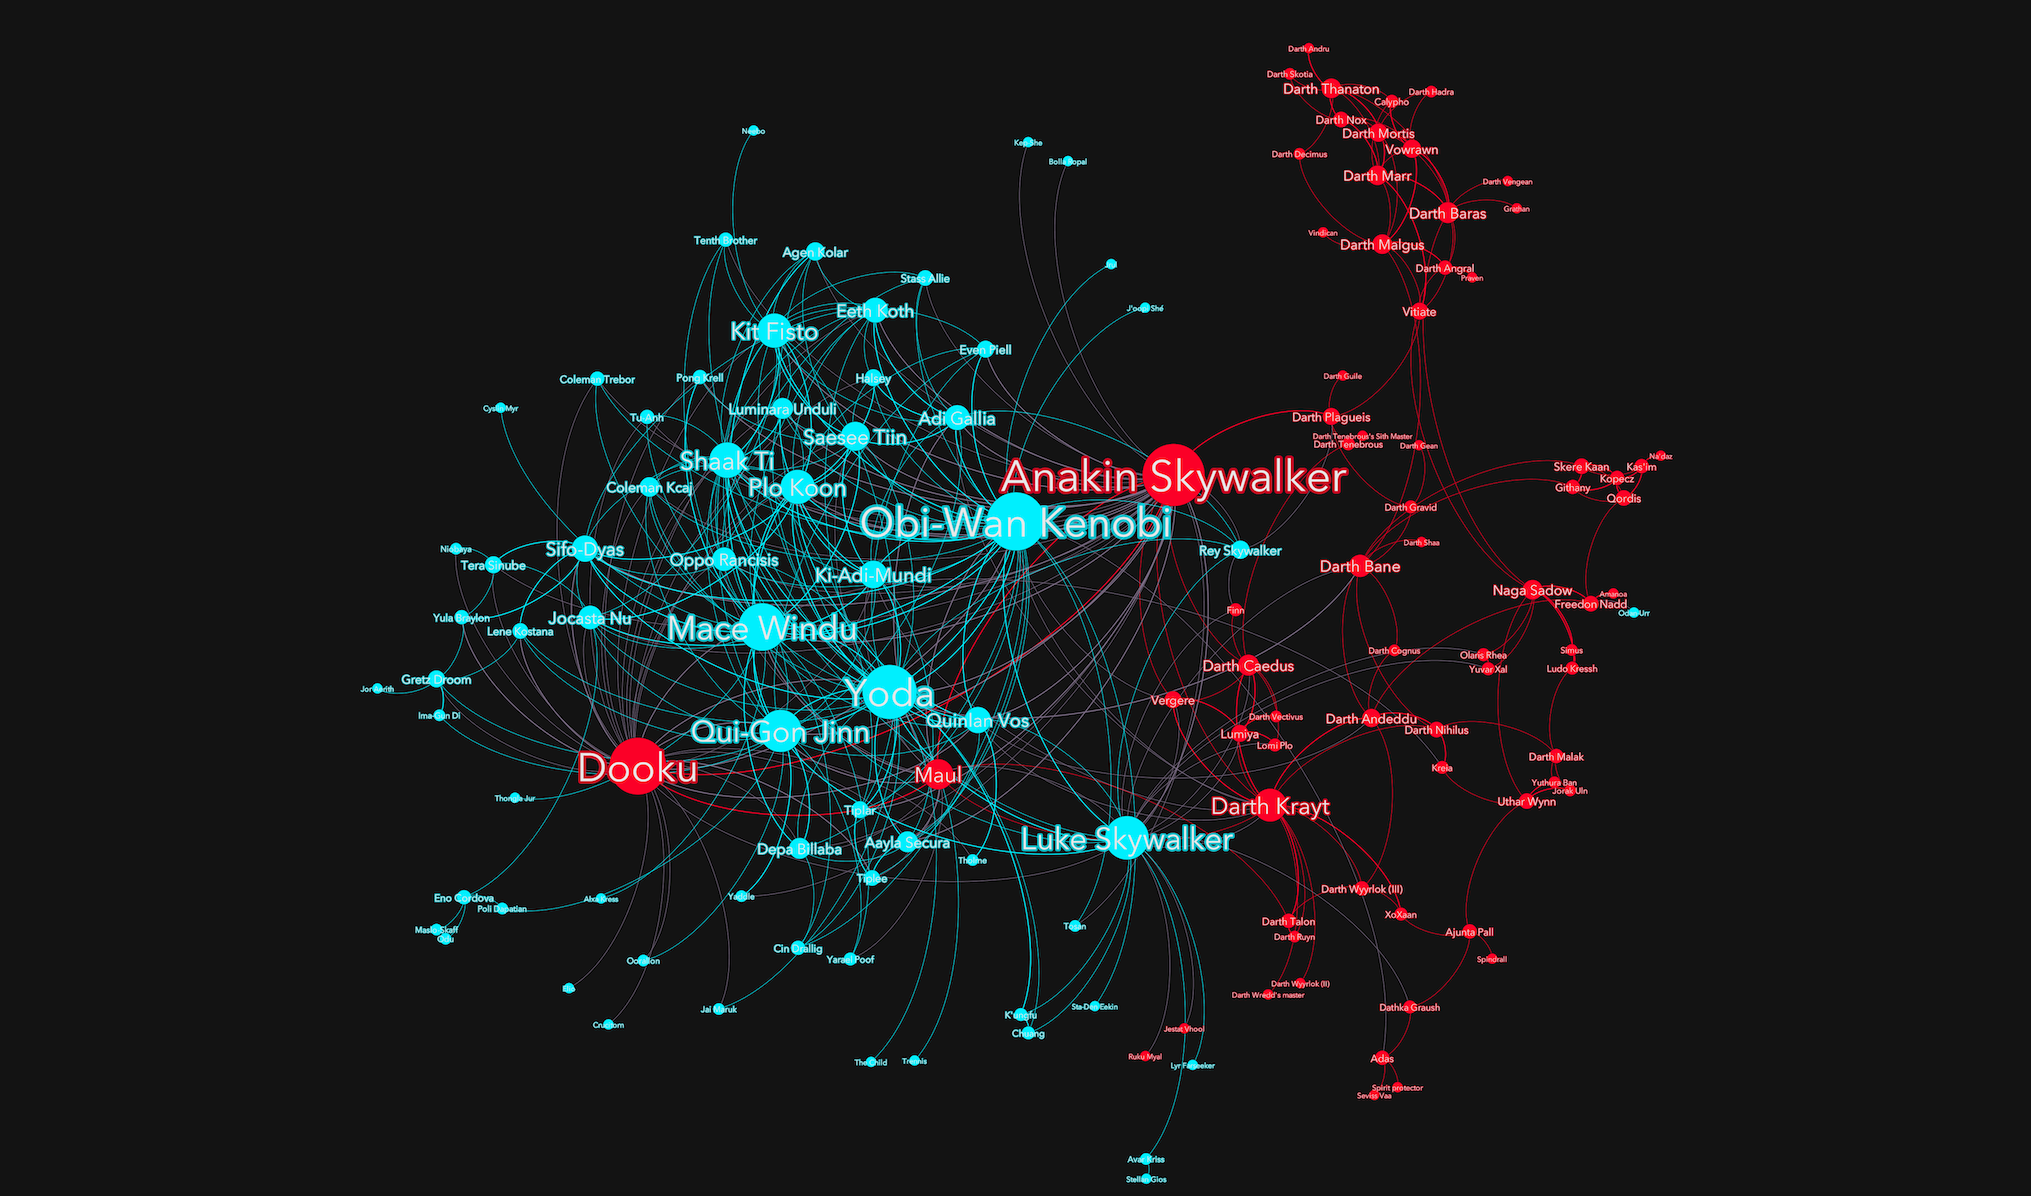


In [23]:
df = pd.DataFrame(dict(
    DEGREE                 =     dict(G.degree),
    DEGREE_CENTRALITY      = nx.degree_centrality(G),
    EIGENVECTOR            = nx.eigenvector_centrality(G),
    CLOSENESS_CENTRALITY   = nx.closeness_centrality(G),
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(G),
    CLUSTCOEF              = nx.clustering(G),
    order                  = name_status
)) 

df.to_csv('features_network.csv')
df.head(5)

,DEGREE,DEGREE_CENTRALITY,EIGENVECTOR,CLOSENESS_CENTRALITY,BETWEENNESS_CENTRALITY,CLUSTCOEF,order
Ajunta Pall,4.0,0.028169,0.001157,0.265045,0.018502,0.00000,sith
Spindrall,1.0,0.007042,0.000071,0.208573,0.000000,0.00000,sith
Darth Nox,5.0,0.035211,0.000042,0.204752,0.004712,0.60000,sith
Darth Thanaton,8.0,0.056338,0.000057,0.212540,0.024608,0.25000,sith
Darth Mortis,7.0,0.049296,0.000172,0.247440,0.016790,0.52381,sith


### 6. Prediction, feature importances

Here I merge the features covering the bio, the textual description, and the network aspect and use them in a binary classification problem where the labels are the jedi/sith flags. The prediction, building on xgboost, puts all these features together and relates them to the two classes. This way we can uncover which of these features has an actual influence/relation on the sith/jedi tags, and use this knowledge (the trained model) to predict whether baby yoda will have a higher chance to belong to one of the orders. The boring technical details are mentioned in the comments below.

In [27]:
# Reading features, checking the little guy

df1 = pd.read_csv('features_wookiepedia.csv', index_col = 0)
df2 = pd.read_csv('features_network.csv', index_col = 0)
df  = df1.merge(df2, left_index = True, right_index = True)
df = df.drop(columns = ['Species'])

print(df.keys())
df[df.index=='The Child']

Index(['Bio_NumSent', 'Bio_Readability', 'Bio_Sent_pos', 'Bio_Sent_neu',
       'Bio_Sent_neg', 'Bio_Sent_comp', 'Order', 'Lightsaber', 'Gender',
       'Hair color', 'Eye color', 'Skin color', 'Height', 'DEGREE',
       'DEGREE_CENTRALITY', 'EIGENVECTOR', 'CLOSENESS_CENTRALITY',
       'BETWEENNESS_CENTRALITY', 'CLUSTCOEF', 'order'],
      dtype='object')


,Bio_NumSent,Bio_Readability,Bio_Sent_pos,Bio_Sent_neu,Bio_Sent_neg,Bio_Sent_comp,Order,Lightsaber,Gender,Hair color,Eye color,Skin color,Height,DEGREE,DEGREE_CENTRALITY,EIGENVECTOR,CLOSENESS_CENTRALITY,BETWEENNESS_CENTRALITY,CLUSTCOEF,order
The Child,218,10.443586,0.068,0.831,0.101,-0.9991,jedi,NaN,Male,white,brown,green,0.0,1.0,0.007042,0.016863,0.296709,0.0,0.0,jedi


In [28]:
# transform the input features. on the one hand, transform the categorical features into dummies
# in the other hand, make sure we have a balanced sample (50:50 each classes) which I will 
# later randomize multiple times and take averages as a final result

def get_balanced_sampleDrop(df):
    minN = min(Counter(df['order']).values())
    df0  = df [df['order']=='jedi'].sample(minN)
    df1  = df [df['order']=='sith'].sample(minN)
    return df0.append(df1)


def encodingLabels(df, feature):
    df_enc = pd.get_dummies(df[feature])
    df_enc = df_enc.rename(columns = {k : feature + '__' + str(k) for k in df_enc.keys()})
    df2    = df.drop(columns = [feature])
    return df2.merge(df_enc, left_index=True,  right_index=True)



df_trans = df.drop(columns = 'Lightsaber').copy()
df_trans = encodingLabels(df_trans, 'Hair color')
df_trans = encodingLabels(df_trans, 'Eye color')
df_trans = encodingLabels(df_trans, 'Skin color')
df_trans = encodingLabels(df_trans, 'Gender')
df_trans = df_trans.fillna(0)
df_trans.head(2)

,Bio_NumSent,Bio_Readability,Bio_Sent_pos,Bio_Sent_neu,Bio_Sent_neg,Bio_Sent_comp,Order,Height,DEGREE,DEGREE_CENTRALITY,...,Skin color__green,Skin color__light,Skin color__orange,Skin color__other,Skin color__pale,Skin color__purple,Skin color__red,Skin color__tan,Gender__Female,Gender__Male
Meloria's Jedi Master,18,7.195312,0.000,1.000,0.000,0.0000,jedi,1.73,0.0,0.000000,...,0,1,0,0,0,0,0,0,0,1
Cin Drallig,57,11.459131,0.033,0.844,0.123,-0.9976,jedi,1.00,4.0,0.028169,...,0,1,0,0,0,0,0,0,0,1


In [42]:
# run 100 predictions on randomly picked balanced samples
# and save the accuracy and feature importance results of each
# classification

feature_value_d = {}
nrand           = 200
pred_res        = []
pred_acc        = []

for rand_iter in range(nrand):
    
    if rand_iter % 10 == 0:
        print('Iteraiton round: ', rand_iter)


    df_b   = get_balanced_sampleDrop(df_trans[df_trans.index!='The Child'])
    X      = df_b.drop(columns = ['Order', 'order'])
    y      = [1 if o == 'jedi' else 0 for o in df_b.Order]
    X_yoda = df_trans[df_trans.index=='The Child'] 


    param_grid =  {'n_estimators'  : [200], 'max_depth'      : [3,4,5] , 
                                            'learning_rate'  : [0.1,0.2, 0.05, 0.01], 
                                            'subsample'      : [0.8,0.9,0.95]}

    grid = GridSearchCV(XGB(), param_grid = param_grid, cv=5)
    grid.fit(X, y)
    
    
    featnames      = X.keys()
    featimportance = grid.best_estimator_.feature_importances_
    featimp        = [(featnames[i],featimportance[i] ) for i in range(len(featimportance))]
    featimp        = sorted(featimp, key=lambda tup: tup[1], reverse = True)[0:100]
    accuracy       = grid.best_score_ 
    #print('Accuracy: ', accuracy)
    
    for (feat, imp) in featimp:
        group = feat.split('__')[0]
        if group not in feature_value_d:
            feature_value_d[group] = imp
        else:
            feature_value_d[group] += imp

    feature_value_d
    featimp2        = [(k, v) for k, v in feature_value_d.items()]
    featimp2        = sorted(featimp2, key=lambda tup: tup[1], reverse = True)[0:100]
    
    pred_res.append(grid.predict(X_yoda.drop(columns = ['Order', 'order']))[0])
    pred_acc.append(accuracy)
    
features, accuracies = zip(*featimp2)
accuracies = [a/nrand for a in accuracies]

Iteraiton round:  0
Iteraiton round:  10
Iteraiton round:  20
Iteraiton round:  30
Iteraiton round:  40
Iteraiton round:  50
Iteraiton round:  60
Iteraiton round:  70
Iteraiton round:  80
Iteraiton round:  90
Iteraiton round:  100
Iteraiton round:  110
Iteraiton round:  120
Iteraiton round:  130
Iteraiton round:  140
Iteraiton round:  150
Iteraiton round:  160
Iteraiton round:  170
Iteraiton round:  180
Iteraiton round:  190


In [43]:
# final results on prediction

print('PREDICTED RESULT:\n')
print('average accuracy: ', round(100*np.mean(pred_acc),2), '\n')

print('Jedi probability:', round(100*sum(pred_res)/nrand, 2))
print('Sith probability:', round(100-100*sum(pred_res)/nrand, 2))

PREDICTED RESULT:

average accuracy:  82.23 

Jedi probability: 80.5
Sith probability: 19.5


In [51]:
plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

Text(0.5, 1.0, 'Feature importances on predicting Jedis')

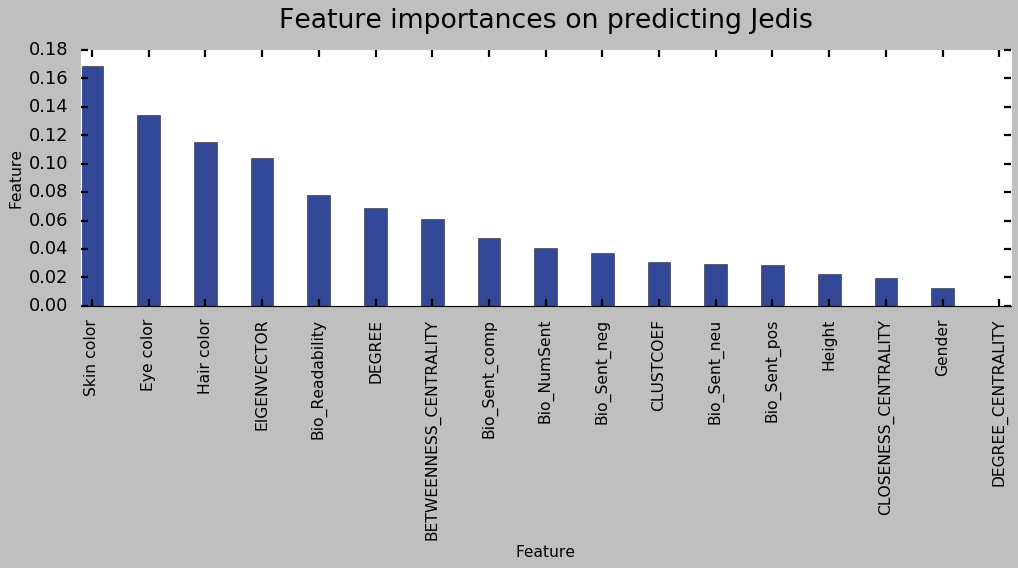

In [59]:
# feature importances on prediction

f, ax = plt.subplots(1,1,figsize=(15,4))
format_axis(ax, 'Feature', 'Importance')
ax.set_xticklabels(features, fontsize = 14, rotation = 90)
ax.bar(features, accuracies, width = 0.4, alpha = 0.8)
ax.set_title('Feature importances on predicting Jedis', fontsize = 24, pad = 20)

# << SPOILER ALERT >>
### << conclusions >>

#### The current prediction that is only relying on the source, and from that source three types of data (bio, description, co-mention network), Baby Yoda has a 90 chance (with an accuracy of 83%) to become a Jedi master in the future as opposed to joining the dark side, while the most predictive features in this seem to be the facial characteristics (skin, eye, and hair color), one's Eigenvector centrality in the network, and the readability index of the profile description.

### 8. Lightsaber barchart

In [39]:
def hsv_to_rgb(h, s, v):
    h, s, v = [float(x) for x in (h, s, v)]
    hi = (h / 60) % 6
    hi = int(round(hi))
    f = (h / 60) - (h / 60)
    p = v * (1 - s)
    q = v * (1 - f * s)
    t = v * (1 - (1 - f) * s)
    if hi == 0:    return v, t, p
    elif hi == 1:  return q, v, p
    elif hi == 2:  return p, v, t
    elif hi == 3:  return p, q, v
    elif hi == 4:  return t, p, v
    elif hi == 5:  return v, p, q

 
def get_colors(h):
    colors = []
    for i in range(100):
        s = min(0.2+i/10.0,1)
        v = min(0.8+i/10.0,1)
        r, g, b = hsv_to_rgb(h, s, v)
        colors.append((r,g,b))    
    return colors


def light_vline(x, y0, ax, colors, N):   
    ymin = [] 
    ymax = []
    width = 1
    for j in range(N):
        y = np.asarray([j/40.0+a+random.random()/10.0 for a in y0])
        y1 = np.asarray([-j/40.0+a+random.random()/10.0 -width for a in y0])
        if j == 0: ymin = y
        if j == 0: ymax = y1
        alpha = max([0.5-0.5*math.log(math.log(j+1)+1)/math.log(math.log(50))+0.1,0.1])
        ax.plot(x,y, color = colors[j], linewidth = 4, alpha = alpha)
        ax.plot(x,y1, color = colors[j], linewidth = 5, alpha = alpha )

    ax.fill_between(x, ymin, ymax, color = 'white')
    plt.rcParams['axes.facecolor'] = 'black'
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_edgecolor('black')   
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


def light_hline(x, y0, ax, colors):
    ymin  = [] 
    ymax  = []
    width = 1
    N     = 40.0
    for j in range(int(N)):
        if j % 2 == 0:
            y = np.asarray([j/N+a+random.random()/10.0 for a in y0])
            y1 = np.asarray([-j/N+a+random.random()/10.0 -width for a in y0])

        if j == 0: ymin = y
        if j == 0: ymax = y1
        alpha = 0.8*max([0.5-0.5*math.log(math.log(j+1)+1)/math.log(math.log(50))+0.1,0.1])
        ax.plot(y,x, color = colors[j], linewidth = 4, alpha = alpha)
        ax.plot(y1,x, color = colors[j], linewidth = 5, alpha = alpha )

    ax.fill_betweenx(x, ymin, ymax, color = 'white')
    plt.rcParams['axes.facecolor'] = 'black'   
    
    
def get_bar(xpos, height):
    y0 = height*[xpos]
    x0 = np.linspace(1,height,height)
    return x0,y0


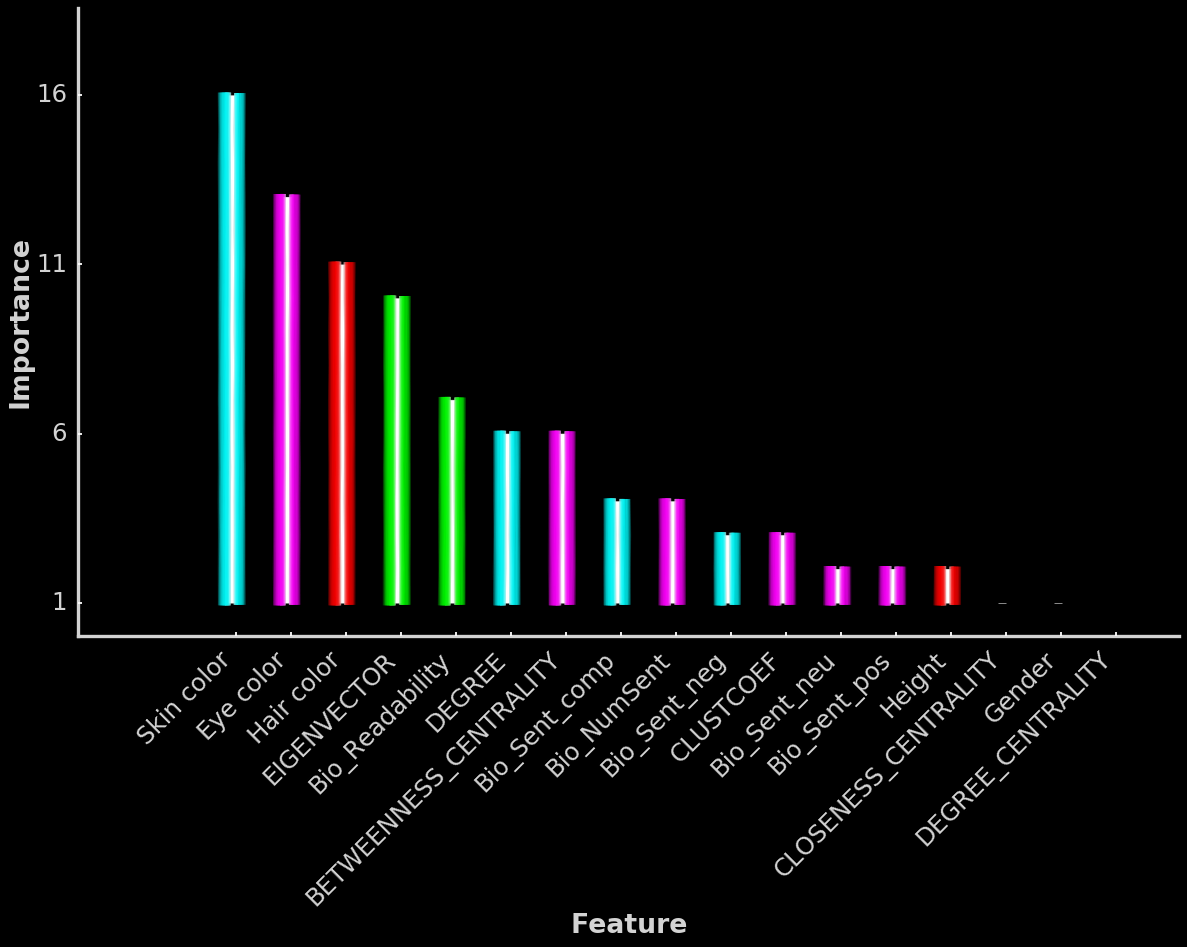

In [65]:
f, ax      = plt.subplots(1,1,figsize=(15,12))
plt.style.use('dark_background')

colors_num = [209, 140, 30, 300]
x0, y0     = zip(*featimp2)  


for ind, height in enumerate(y0):
    height = int(100*height/nrand)
    xpos   = 7*ind
    colors = get_colors(random.choice(colors_num))
    x, y   = get_bar(xpos, height)
    light_hline(x, y, ax, colors)


maxi   = max(y0)*1.1*100/nrand
yticks = [int(a) for a in np.arange(1, maxi, 5)] 
ax.set_ylim(0,maxi)


ax.set_xlabel('Feature', fontsize = 24, labelpad = 2,     color = 'lightgrey',fontweight='bold')
ax.set_ylabel('Importance', fontsize = 24, labelpad = 2, color = 'lightgrey',fontweight='bold')
ax.set_yticks(yticks)
ax.set_yticklabels([str(a) for a in yticks], fontsize = 22,  color = 'lightgrey')
ax.set_xticks([7*ind for ind in range(len(y0))])
ax.set_xticklabels(x0, fontsize = 22,  color = 'lightgrey', rotation = 45, ha = 'right')
ax.tick_params(axis='x', which='major', pad=10)
ax.tick_params(axis='y', which='major', pad=10)

axis_format_b(ax)
plt.tight_layout()